In [1]:
import matplotlib.patches as patches
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
from matplotlib import gridspec

COMMON_MODELS = ['CMCC-ESM2', 'CESM2-WACCM','NorESM2-MM', 'TaiESM1', 'EC-Earth3-Veg','CMCC-CM2-SR5', 'BCC-CSM2-MR']

def add_unified_colorbar(fig, ax, mesh, label):
    pos = ax.get_position()

    # 颜色条定位参数：在子图底部下方固定距离，宽度为子图宽度70%
    cax_height = 0.01  # 颜色条高度（固定值）
    cax_width = pos.width * 0.7  # 颜色条宽度
    cax_y = pos.y0 - cax_height - 0.035  # 距离子图底部固定距离
    cax_x = pos.x0 + pos.width * 0.15  # 水平居中

    # 创建颜色条坐标轴
    cax = fig.add_axes([cax_x, cax_y, cax_width, cax_height])

    # 添加颜色条
    cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal', extend='both')
    if 'SSP' in label:
        # 在 colorbar 上方左侧添加文字
        cbar.ax.text(0, 1.2, "Decrease", ha='left', va='bottom', fontsize=16, transform=cbar.ax.transAxes)

        # 在 colorbar 上方右侧添加文字
        cbar.ax.text(1, 1.2, "Increase", ha='right', va='bottom', fontsize=16, transform=cbar.ax.transAxes)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(label, fontsize=18)

    return cbar

# 绘制矩形地图（输入矩形四角坐标）
def draw_rectange_map(hotpoint, dd, fig=False, ax=None, extent=[-180, 180, -60, 90], linewi=1, lines='-'):
    if fig == False:
        fig = plt.figure(figsize=(12.27, 6.69), dpi=100, facecolor='white')
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.LAND, facecolor='#FFE9B5')

    ax.plot([hotpoint[dd][2], hotpoint[dd][3]], [hotpoint[dd][1], hotpoint[dd][1]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)
    ax.plot([hotpoint[dd][2], hotpoint[dd][3]], [hotpoint[dd][0], hotpoint[dd][0]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)
    ax.plot([hotpoint[dd][2], hotpoint[dd][2]], [hotpoint[dd][0], hotpoint[dd][1]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)
    ax.plot([hotpoint[dd][3], hotpoint[dd][3]], [hotpoint[dd][0], hotpoint[dd][1]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)

def draw_hotpoint_labels(hotpoint_label, fig=None, ax=None, fontsize=16, fontweight='bold', color='black'):
    """
    在指定坐标位置标注区域名称

    参数:
    hotpoint_label: 包含区域名称和标注坐标的字典
    fig: 图形对象
    ax: 坐标轴对象
    fontsize: 字体大小
    fontweight: 字体粗细
    color: 文字颜色
    """
    for region_name, coords in hotpoint_label.items():
        lat, lon = coords
        ax.text(lon, lat, region_name,
                fontsize=fontsize,
                fontweight=fontweight,
                color=color,
                ha='center',      # 水平对齐方式
                va='center',      # 垂直对齐方式
                transform=ccrs.PlateCarree(),)

In [2]:
def plot_supplementary_fig8a(fig, ax):
    # 主数据层 MMWM 数据变化
    SOC_hist = xr.open_dataset("F:/008_Screening_data_CMIP6/soc/soc_historical_1985-2014.nc")['soc'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    SOC_ssp245_future = xr.open_dataset("F:/008_Screening_data_CMIP6/soc/soc_ssp245_2070-2099.nc")['soc'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    SOC_data = (SOC_ssp245_future - SOC_hist) / SOC_hist * 100  # 计算百分比变化
    SOC_data = xr.where(SOC_data > 100, 100, SOC_data)  # 限制最大值100
    SOC_data_change = SOC_ssp245_future - SOC_hist  # 变化掩膜
    SOC_data_change = xr.where(SOC_data_change > 0, 1, xr.where(SOC_data_change < 0, -1, 0))  # 直接生成-1 0 1掩膜
    model_change = {}
    model_change['MMWM'] = SOC_data_change
    # 每个模型的变化
    for model in COMMON_MODELS:
        model_hist = xr.open_dataset(f"F:/007_CorrectAndRepair_data_CMIP6/{model}/{model}_SeasonAndLand_corrected_soc.nc")['ssp245_soc'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
        model_future = xr.open_dataset(f"F:/007_CorrectAndRepair_data_CMIP6/{model}/{model}_SeasonAndLand_corrected_soc.nc")['ssp245_soc'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
        model_change_data = model_future - model_hist
        model_change_data = xr.where(model_change_data > 0, 1, xr.where(model_change_data < 0, -1, 0))  # 直接生成-1 0 1掩膜
        model_change[model] = model_change_data

    # 逐像元计算模型认同这一变化掩膜
    # 初始化一个与MMWM相同形状的数组，用于存储模型认同结果
    agreement_increase = xr.zeros_like(model_change['MMWM'])
    agreement_decrease = xr.zeros_like(model_change['MMWM'])

    # 计算每个像素点上有多少模型与MMWM同方向变化（正值或负值）
    for model in COMMON_MODELS:
        if model != 'MMWM':
            # 检查是否认同增加（MMWM=1 且 模型=1）
            agreement_increase += (model_change['MMWM'] == 1) & (model_change[model] == 1)
            # 检查是否认同减少（MMWM=-1 且 模型=-1）
            agreement_decrease += (model_change['MMWM'] == -1) & (model_change[model] == -1)

    # 计算比例（总模型数不包括MMWM）
    total_others = len(COMMON_MODELS)
    agreement_mask_increase = (agreement_increase / total_others) >= 5/7
    agreement_mask_decrease = (agreement_decrease / total_others) >= 5/7

    # 增加区域：认同且MMWM=1 → 标记为1
    mask_increase = xr.where(agreement_mask_increase & (model_change['MMWM'] == 1), 1, np.nan)
    # 减少区域：认同且MMWM=-1 → 标记为-1
    mask_decrease = xr.where(agreement_mask_decrease & (model_change['MMWM'] == -1), -1, np.nan)

    # 合并结果
    final_mask = mask_increase.fillna(0) + mask_decrease.fillna(0)
    final_mask = final_mask.where(final_mask != 0)  # 保留1或-1，其余为NaN

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 绘制主数据层（观测值）
    # mesh = ax.pcolormesh(SOC_data.lon, SOC_data.lat, SOC_data,cmap="YlGn",transform=ccrs.PlateCarree(),shading='auto',)# 自动选择阴影模式

    # 获取数据范围
    lons = SOC_data.lon.values
    lats = SOC_data.lat.values

    lon_min, lon_max = SOC_data.lon.min().values, SOC_data.lon.max().values
    lat_min, lat_max = SOC_data.lat.min().values, SOC_data.lat.max().values

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(SOC_data.lon)
    d_lat = (lat_max - lat_min) / len(SOC_data.lat)

    # 设置colormap和norm
    cmap = plt.get_cmap("seismic")
    vmin = SOC_data.min().item()
    vmax = SOC_data.max().item()
    # norm = plt.Normalize(vmin, vmax)
    norm = plt.Normalize(-100, 100)
    
    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            # 跳过海洋/无效值
            if np.isnan(SOC_data[i, j].item()):
                continue

            value = SOC_data[i, j].item()

            # 创建圆角矩形路径
            patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor=cmap(norm(value)),
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder=1
                )
            ax.add_patch(patch)

    # 只在final_mask为1的地方画点
    mask_points = np.where(np.isfinite(final_mask.values))
    final_mask_lons = final_mask.lon.values[mask_points[1]]
    final_mask_lats = final_mask.lat.values[mask_points[0]]
    ax.scatter(final_mask_lons, final_mask_lats, color='black', s=0.3, alpha=0.7, transform=ccrs.PlateCarree(), zorder=3)
    
    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

    """# 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax)"""
    
    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'black'}
    gl.ylabel_style = {'size': 20, 'color': 'black'}
    

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    cbar = add_unified_colorbar(fig, ax, sm, "Future $SOC$ Change SSP2-4.5 (%)")
    cbar.set_ticks(np.arange(-100, 100, 20))

    # 添加图例标识
    ax.text(-0.05, 1.05, 'a',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [3]:
def plot_supplementary_fig8b(fig, ax):
    # 主数据层 MMWM 数据变化
    SOC_hist = xr.open_dataset("F:/008_Screening_data_CMIP6/soc/soc_historical_1985-2014.nc")['soc'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    SOC_ssp370_future = xr.open_dataset("F:/008_Screening_data_CMIP6/soc/soc_ssp370_2070-2099.nc")['soc'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    SOC_data = (SOC_ssp370_future - SOC_hist) / SOC_hist * 100  # 计算百分比变化
    SOC_data = xr.where(SOC_data > 100, 100, SOC_data)  # 限制最大值100
    SOC_data_change = SOC_ssp370_future - SOC_hist  # 变化掩膜
    SOC_data_change = xr.where(SOC_data_change > 0, 1, xr.where(SOC_data_change < 0, -1, 0))  # 直接生成-1 0 1掩膜
    model_change = {}
    model_change['MMWM'] = SOC_data_change
    # 每个模型的变化
    for model in COMMON_MODELS:
        model_hist = xr.open_dataset(f"F:/007_CorrectAndRepair_data_CMIP6/{model}/{model}_SeasonAndLand_corrected_soc.nc")['ssp370_soc'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
        model_future = xr.open_dataset(f"F:/007_CorrectAndRepair_data_CMIP6/{model}/{model}_SeasonAndLand_corrected_soc.nc")['ssp370_soc'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
        model_change_data = model_future - model_hist
        model_change_data = xr.where(model_change_data > 0, 1, xr.where(model_change_data < 0, -1, 0))  # 直接生成-1 0 1掩膜
        model_change[model] = model_change_data

    # 逐像元计算模型认同这一变化掩膜
    # 初始化一个与MMWM相同形状的数组，用于存储模型认同结果
    agreement_increase = xr.zeros_like(model_change['MMWM'])
    agreement_decrease = xr.zeros_like(model_change['MMWM'])

    # 计算每个像素点上有多少模型与MMWM同方向变化（正值或负值）
    for model in COMMON_MODELS:
        if model != 'MMWM':
            # 检查是否认同增加（MMWM=1 且 模型=1）
            agreement_increase += (model_change['MMWM'] == 1) & (model_change[model] == 1)
            # 检查是否认同减少（MMWM=-1 且 模型=-1）
            agreement_decrease += (model_change['MMWM'] == -1) & (model_change[model] == -1)

    # 计算比例（总模型数不包括MMWM）
    total_others = len(COMMON_MODELS)
    agreement_mask_increase = (agreement_increase / total_others) >= 5/7
    agreement_mask_decrease = (agreement_decrease / total_others) >= 5/7

    # 增加区域：认同且MMWM=1 → 标记为1
    mask_increase = xr.where(agreement_mask_increase & (model_change['MMWM'] == 1), 1, np.nan)
    # 减少区域：认同且MMWM=-1 → 标记为-1
    mask_decrease = xr.where(agreement_mask_decrease & (model_change['MMWM'] == -1), -1, np.nan)

    # 合并结果
    final_mask = mask_increase.fillna(0) + mask_decrease.fillna(0)
    final_mask = final_mask.where(final_mask != 0)  # 保留1或-1，其余为NaN

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 绘制主数据层（观测值）
    # mesh = ax.pcolormesh(SOC_data.lon, SOC_data.lat, SOC_data,cmap="YlGn",transform=ccrs.PlateCarree(),shading='auto',)# 自动选择阴影模式

    # 获取数据范围
    lons = SOC_data.lon.values
    lats = SOC_data.lat.values

    lon_min, lon_max = SOC_data.lon.min().values, SOC_data.lon.max().values
    lat_min, lat_max = SOC_data.lat.min().values, SOC_data.lat.max().values

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(SOC_data.lon)
    d_lat = (lat_max - lat_min) / len(SOC_data.lat)

    # 设置colormap和norm
    cmap = plt.get_cmap("seismic")
    vmin = SOC_data.min().item()
    vmax = SOC_data.max().item()
    # norm = plt.Normalize(vmin, vmax)
    norm = plt.Normalize(-100, 100)
    
    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            # 跳过海洋/无效值
            if np.isnan(SOC_data[i, j].item()):
                continue

            value = SOC_data[i, j].item()

            # 创建圆角矩形路径
            patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor=cmap(norm(value)),
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder=1
                )
            ax.add_patch(patch)

    # 只在final_mask为1的地方画点
    mask_points = np.where(np.isfinite(final_mask.values))
    final_mask_lons = final_mask.lon.values[mask_points[1]]
    final_mask_lats = final_mask.lat.values[mask_points[0]]
    ax.scatter(final_mask_lons, final_mask_lats, color='black', s=0.3, alpha=0.7, transform=ccrs.PlateCarree(), zorder=3)
    
    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

    """# 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax)"""
    
    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'black'}
    gl.ylabel_style = {'size': 20, 'color': 'black'}
    

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    cbar = add_unified_colorbar(fig, ax, sm, "Future $SOC$ Change SSP3-7.0 (%)")
    cbar.set_ticks(np.arange(-100, 100, 20))

    # 添加图例标识
    ax.text(-0.05, 1.05, 'b',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [4]:
def plot_supplementary_fig8c(fig, ax):
    # 主数据层 MMWM 数据变化
    Rh_hist = xr.open_dataset("F:/008_Screening_data_CMIP6/rh/rh_historical_1985-2014.nc")['rh'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    Rh_ssp245_future = xr.open_dataset("F:/008_Screening_data_CMIP6/rh/rh_ssp245_2070-2099.nc")['rh'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    Rh_data = (Rh_ssp245_future - Rh_hist) / Rh_hist * 100  # 计算百分比变化
    Rh_data = xr.where(Rh_data > 100, 100, Rh_data)  # 限制最大值100
    Rh_data_change = Rh_ssp245_future - Rh_hist  # 变化掩膜
    Rh_data_change = xr.where(Rh_data_change > 0, 1, xr.where(Rh_data_change < 0, -1, 0))  # 直接生成-1 0 1掩膜
    model_change = {}
    model_change['MMWM'] = Rh_data_change
    # 每个模型的变化
    for model in COMMON_MODELS:
        model_hist = xr.open_dataset(f"F:/007_CorrectAndRepair_data_CMIP6/{model}/{model}_SeasonAndLand_corrected_rh.nc")['ssp245_rh'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
        model_future = xr.open_dataset(f"F:/007_CorrectAndRepair_data_CMIP6/{model}/{model}_SeasonAndLand_corrected_rh.nc")['ssp245_rh'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
        model_change_data = model_future - model_hist
        model_change_data = xr.where(model_change_data > 0, 1, xr.where(model_change_data < 0, -1, 0))  # 直接生成-1 0 1掩膜
        model_change[model] = model_change_data

    # 逐像元计算模型认同这一变化掩膜
    # 初始化一个与MMWM相同形状的数组，用于存储模型认同结果
    agreement_increase = xr.zeros_like(model_change['MMWM'])
    agreement_decrease = xr.zeros_like(model_change['MMWM'])

    # 计算每个像素点上有多少模型与MMWM同方向变化（正值或负值）
    for model in COMMON_MODELS:
        if model != 'MMWM':
            # 检查是否认同增加（MMWM=1 且 模型=1）
            agreement_increase += (model_change['MMWM'] == 1) & (model_change[model] == 1)
            # 检查是否认同减少（MMWM=-1 且 模型=-1）
            agreement_decrease += (model_change['MMWM'] == -1) & (model_change[model] == -1)

    # 计算比例（总模型数不包括MMWM）
    total_others = len(COMMON_MODELS)
    agreement_mask_increase = (agreement_increase / total_others) >= 5/7
    agreement_mask_decrease = (agreement_decrease / total_others) >= 5/7

    # 增加区域：认同且MMWM=1 → 标记为1
    mask_increase = xr.where(agreement_mask_increase & (model_change['MMWM'] == 1), 1, np.nan)
    # 减少区域：认同且MMWM=-1 → 标记为-1
    mask_decrease = xr.where(agreement_mask_decrease & (model_change['MMWM'] == -1), -1, np.nan)

    # 合并结果
    final_mask = mask_increase.fillna(0) + mask_decrease.fillna(0)
    final_mask = final_mask.where(final_mask != 0)  # 保留1或-1，其余为NaN

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 绘制主数据层（观测值）
    # mesh = ax.pcolormesh(Rh_data.lon, Rh_data.lat, Rh_data,cmap="YlGn",transform=ccrs.PlateCarree(),shading='auto',)# 自动选择阴影模式

    # 获取数据范围
    lons = Rh_data.lon.values
    lats = Rh_data.lat.values

    lon_min, lon_max = Rh_data.lon.min().values, Rh_data.lon.max().values
    lat_min, lat_max = Rh_data.lat.min().values, Rh_data.lat.max().values

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(Rh_data.lon)
    d_lat = (lat_max - lat_min) / len(Rh_data.lat)

    # 设置colormap和norm
    cmap = plt.get_cmap("seismic")
    vmin = Rh_data.min().item()
    vmax = Rh_data.max().item()
    # norm = plt.Normalize(vmin, vmax)
    norm = plt.Normalize(-100, 100)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            # 跳过海洋/无效值
            if np.isnan(Rh_data[i, j].item()):
                continue

            value = Rh_data[i, j].item()

            # 创建圆角矩形路径
            patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor=cmap(norm(value)),
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder=1
                )
            ax.add_patch(patch)

    # 只在final_mask为1的地方画点
    mask_points = np.where(np.isfinite(final_mask.values))
    final_mask_lons = final_mask.lon.values[mask_points[1]]
    final_mask_lats = final_mask.lat.values[mask_points[0]]
    ax.scatter(final_mask_lons, final_mask_lats, color='black', s=0.3, alpha=0.7, transform=ccrs.PlateCarree(), zorder=3)

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

    """# 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax)"""

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'black'}
    gl.ylabel_style = {'size': 20, 'color': 'black'}


    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    cbar = add_unified_colorbar(fig, ax, sm, "Future $R_h$ Change SSP2-4.5 (%)")
    cbar.set_ticks(np.arange(-100, 100, 20))

    # 添加图例标识
    ax.text(-0.05, 1.05, 'c',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [5]:
def plot_supplementary_fig8d(fig, ax):
    # 主数据层 MMWM 数据变化
    Rh_hist = xr.open_dataset("F:/008_Screening_data_CMIP6/rh/rh_historical_1985-2014.nc")['rh'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    Rh_ssp370_future = xr.open_dataset("F:/008_Screening_data_CMIP6/rh/rh_ssp370_2070-2099.nc")['rh'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    Rh_data = (Rh_ssp370_future - Rh_hist) / Rh_hist * 100  # 计算百分比变化
    Rh_data = xr.where(Rh_data > 100, 100, Rh_data)  # 限制最大值100
    Rh_data_change = Rh_ssp370_future - Rh_hist  # 变化掩膜
    Rh_data_change = xr.where(Rh_data_change > 0, 1, xr.where(Rh_data_change < 0, -1, 0))  # 直接生成-1 0 1掩膜
    model_change = {}
    model_change['MMWM'] = Rh_data_change
    # 每个模型的变化
    for model in COMMON_MODELS:
        model_hist = xr.open_dataset(f"F:/007_CorrectAndRepair_data_CMIP6/{model}/{model}_SeasonAndLand_corrected_rh.nc")['ssp370_rh'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
        model_future = xr.open_dataset(f"F:/007_CorrectAndRepair_data_CMIP6/{model}/{model}_SeasonAndLand_corrected_rh.nc")['ssp370_rh'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
        model_change_data = model_future - model_hist
        model_change_data = xr.where(model_change_data > 0, 1, xr.where(model_change_data < 0, -1, 0))  # 直接生成-1 0 1掩膜
        model_change[model] = model_change_data

    # 逐像元计算模型认同这一变化掩膜
    # 初始化一个与MMWM相同形状的数组，用于存储模型认同结果
    agreement_increase = xr.zeros_like(model_change['MMWM'])
    agreement_decrease = xr.zeros_like(model_change['MMWM'])

    # 计算每个像素点上有多少模型与MMWM同方向变化（正值或负值）
    for model in COMMON_MODELS:
        if model != 'MMWM':
            # 检查是否认同增加（MMWM=1 且 模型=1）
            agreement_increase += (model_change['MMWM'] == 1) & (model_change[model] == 1)
            # 检查是否认同减少（MMWM=-1 且 模型=-1）
            agreement_decrease += (model_change['MMWM'] == -1) & (model_change[model] == -1)

    # 计算比例（总模型数不包括MMWM）
    total_others = len(COMMON_MODELS)
    agreement_mask_increase = (agreement_increase / total_others) >= 5/7
    agreement_mask_decrease = (agreement_decrease / total_others) >= 5/7

    # 增加区域：认同且MMWM=1 → 标记为1
    mask_increase = xr.where(agreement_mask_increase & (model_change['MMWM'] == 1), 1, np.nan)
    # 减少区域：认同且MMWM=-1 → 标记为-1
    mask_decrease = xr.where(agreement_mask_decrease & (model_change['MMWM'] == -1), -1, np.nan)

    # 合并结果
    final_mask = mask_increase.fillna(0) + mask_decrease.fillna(0)
    final_mask = final_mask.where(final_mask != 0)  # 保留1或-1，其余为NaN

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 绘制主数据层（观测值）
    # mesh = ax.pcolormesh(Rh_data.lon, Rh_data.lat, Rh_data,cmap="YlGn",transform=ccrs.PlateCarree(),shading='auto',)# 自动选择阴影模式

    # 获取数据范围
    lons = Rh_data.lon.values
    lats = Rh_data.lat.values

    lon_min, lon_max = Rh_data.lon.min().values, Rh_data.lon.max().values
    lat_min, lat_max = Rh_data.lat.min().values, Rh_data.lat.max().values

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(Rh_data.lon)
    d_lat = (lat_max - lat_min) / len(Rh_data.lat)

    # 设置colormap和norm
    cmap = plt.get_cmap("seismic")
    vmin = Rh_data.min().item()
    vmax = Rh_data.max().item()
    # norm = plt.Normalize(vmin, vmax)
    norm = plt.Normalize(-100, 100)
    
    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            # 跳过海洋/无效值
            if np.isnan(Rh_data[i, j].item()):
                continue

            value = Rh_data[i, j].item()

            # 创建圆角矩形路径
            patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor=cmap(norm(value)),
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder=1
                )
            ax.add_patch(patch)

    # 只在final_mask为1的地方画点
    mask_points = np.where(np.isfinite(final_mask.values))
    final_mask_lons = final_mask.lon.values[mask_points[1]]
    final_mask_lats = final_mask.lat.values[mask_points[0]]
    ax.scatter(final_mask_lons, final_mask_lats, color='black', s=0.3, alpha=0.7, transform=ccrs.PlateCarree(), zorder=3)
    
    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

    """# 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax)"""
    
    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'black'}
    gl.ylabel_style = {'size': 20, 'color': 'black'}
    

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    cbar = add_unified_colorbar(fig, ax, sm, "Future $R_h$ Change SSP3-7.0 (%)")
    cbar.set_ticks(np.arange(-100, 100, 20))

    # 添加图例标识
    ax.text(-0.05, 1.05, 'd',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [6]:
def plot_supplementary_fig8e(fig, ax):
    MMEMean_historical = xr.open_dataset("F:/007-1_MEM_data_CMIP6/raw/soc_MMEM.nc")['ssp245_soc'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    MMEMean_future = xr.open_dataset("F:/007-1_MEM_data_CMIP6/raw/soc_MMEM.nc")['ssp245_soc'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    MMWMean_historical = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/soc_MMWM.nc")['ssp245_soc'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    MMWMean_future = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/soc_MMWM.nc")['ssp245_soc'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    SOC_data = xr.open_dataset("E:/Drought_And_SOC/000_observasion_data_ERA5/01_preprocessed_data/merged_csoil_data.nc")

    latitudes = SOC_data.lat.values

    # 模型平均相对观测中位数的偏差
    MMEMean_relative = MMEMean_future - MMEMean_historical
    MMEMean_relative_mean = MMEMean_relative.mean(dim='lon')
    MMEMean_relative_std = MMEMean_relative.std(dim='lon')

    MMWMean_relative = MMWMean_future - MMWMean_historical
    MMWMean_relative_mean = MMWMean_relative.mean(dim='lon')
    MMWMean_relative_std = MMWMean_relative.std(dim='lon')

    # 绘制均值曲线
    mean_line1, = ax.plot(MMEMean_relative_mean, latitudes, color='darkred', linewidth=2, linestyle='-', label='MMEM Mean')

    # 绘制标准差区域（均值±标准差）
    ax.fill_betweenx(latitudes, MMEMean_relative_mean - MMEMean_relative_std, MMEMean_relative_mean + MMEMean_relative_std, color='lightcoral', alpha=0.5)

    # 绘制均值曲线
    mean_line2, = ax.plot(MMWMean_relative_mean, latitudes,
                        color='darkblue',
                        linewidth=2,
                        linestyle='--',
                        label='MMWM Mean')

    # 绘制标准差区域（均值±标准差）
    ax.fill_betweenx(latitudes,
                    MMWMean_relative_mean - MMWMean_relative_std,
                    MMWMean_relative_mean + MMWMean_relative_std,
                    color='skyblue',
                    alpha=0.5, # label='±1 Std Dev'
                    )

    ax.set_xlabel("$SOC$ change\nSSP2-4.5\n(kgC $m^{-2}$)", fontsize=20)
    ax.set_ylabel("Latitude(°N)", fontsize=20)

    # 添加网格
    ax.grid(False)  # , linestyle='--', alpha=0.7)
    # 隐藏上侧和右侧的坐标轴
    ax.spines['top'].set_visible(False)  # 隐藏上侧边框
    ax.spines['right'].set_visible(False)  # 隐藏右侧边框
    ax.spines['bottom'].set_visible(True)  # 显示下侧边框
    ax.spines['left'].set_visible(True)  # 显示左侧边框

    # 添加图例
    # ax.legend(fontsize=15, loc='upper right')

    # 设置Y轴刻度位置为纬度
    ax.set_yticks(np.arange(-60, 91, 30))
    # 设置x轴范围
    ax.set_xlim(auto=True)# [-0.5, 1.5])

    # 设置刻度
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)

    # 添加0值参考线
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

    # 添加图例标识
    ax.text(-0.4, 1, 'e',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

In [7]:
def plot_supplementary_fig8f(fig, ax):
    MMEMean_historical = xr.open_dataset("F:/007-1_MEM_data_CMIP6/raw/soc_MMEM.nc")['ssp370_soc'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    MMEMean_future = xr.open_dataset("F:/007-1_MEM_data_CMIP6/raw/soc_MMEM.nc")['ssp370_soc'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    MMWMean_historical = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/soc_MMWM.nc")['ssp370_soc'].sel(time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    MMWMean_future = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/soc_MMWM.nc")['ssp370_soc'].sel(time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    SOC_data = xr.open_dataset("E:/Drought_And_SOC/000_observasion_data_ERA5/01_preprocessed_data/merged_csoil_data.nc")

    latitudes = SOC_data.lat.values

    # 模型平均相对观测中位数的偏差
    MMEMean_relative = MMEMean_future - MMEMean_historical
    MMEMean_relative_mean = MMEMean_relative.mean(dim='lon')
    MMEMean_relative_std = MMEMean_relative.std(dim='lon')

    MMWMean_relative = MMWMean_future - MMWMean_historical
    MMWMean_relative_mean = MMWMean_relative.mean(dim='lon')
    MMWMean_relative_std = MMWMean_relative.std(dim='lon')

    # 绘制均值曲线
    mean_line1, = ax.plot(MMEMean_relative_mean, latitudes, color='darkred', linewidth=2, linestyle='-', label='MMEM Mean')

    # 绘制标准差区域（均值±标准差）
    ax.fill_betweenx(latitudes, MMEMean_relative_mean - MMEMean_relative_std, MMEMean_relative_mean + MMEMean_relative_std, color='lightcoral', alpha=0.5)

    # 绘制均值曲线
    mean_line2, = ax.plot(MMWMean_relative_mean, latitudes,
                        color='darkblue',
                        linewidth=2,
                        linestyle='--',
                        label='MMWM Mean')

    # 绘制标准差区域（均值±标准差）
    ax.fill_betweenx(latitudes,
                    MMWMean_relative_mean - MMWMean_relative_std,
                    MMWMean_relative_mean + MMWMean_relative_std,
                    color='skyblue',
                    alpha=0.5, # label='±1 Std Dev'
                    )

    ax.set_xlabel("$SOC$ change\nSSP3-7.0\n(kgC $m^{-2}$)", fontsize=20)
    ax.set_ylabel("Latitude(°N)", fontsize=20)

    # 添加网格
    ax.grid(False)  # , linestyle='--', alpha=0.7)
    # 隐藏上侧和右侧的坐标轴
    ax.spines['top'].set_visible(False)  # 隐藏上侧边框
    ax.spines['right'].set_visible(False)  # 隐藏右侧边框
    ax.spines['bottom'].set_visible(True)  # 显示下侧边框
    ax.spines['left'].set_visible(True)  # 显示左侧边框

    # 添加图例
    # ax.legend(fontsize=15, loc='upper right')

    # 设置Y轴刻度位置为纬度
    ax.set_yticks(np.arange(-60, 91, 30))
    # 设置x轴范围
    ax.set_xlim(auto=True)# [-0.5, 1.5])

    # 设置刻度
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)

    # 添加0值参考线
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

    # 添加图例标识
    ax.text(-0.4, 1, 'f',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

In [8]:
def plot_supplementary_fig8g(fig, ax):
    MMEMean_historical = xr.open_dataset("F:/007-1_MEM_data_CMIP6/raw/rh_MMEM.nc")['ssp245_rh'].sel(
        time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    MMEMean_future = xr.open_dataset("F:/007-1_MEM_data_CMIP6/raw/rh_MMEM.nc")['ssp245_rh'].sel(
        time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    MMWMean_historical = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/rh_MMWM.nc")['ssp245_rh'].sel(
        time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    MMWMean_future = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/rh_MMWM.nc")['ssp245_rh'].sel(
        time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    Rh_data = xr.open_dataset("E:/Drought_And_SOC/000_observasion_data_ERA5/01_preprocessed_data/merged_rh_data.nc")

    latitudes = Rh_data.lat.values

    # 模型平均相对观测中位数的偏差
    MMEMean_relative = MMEMean_future - MMEMean_historical
    MMEMean_relative_mean = MMEMean_relative.mean(dim='lon')
    MMEMean_relative_std = MMEMean_relative.std(dim='lon')

    MMWMean_relative = MMWMean_future - MMWMean_historical
    MMWMean_relative_mean = MMWMean_relative.mean(dim='lon')
    MMWMean_relative_std = MMWMean_relative.std(dim='lon')

    # 绘制均值曲线
    mean_line1, = ax.plot(MMEMean_relative_mean, latitudes, color='darkred', linewidth=2, linestyle='-',
                          label='MMEM Mean')

    # 绘制标准差区域（均值±标准差）
    ax.fill_betweenx(latitudes, MMEMean_relative_mean - MMEMean_relative_std,
                     MMEMean_relative_mean + MMEMean_relative_std, color='lightcoral', alpha=0.5)

    # 绘制均值曲线
    mean_line2, = ax.plot(MMWMean_relative_mean, latitudes,
                          color='darkblue',
                          linewidth=2,
                          linestyle='--',
                          label='MMWM Mean')

    # 绘制标准差区域（均值±标准差）
    ax.fill_betweenx(latitudes,
                     MMWMean_relative_mean - MMWMean_relative_std,
                     MMWMean_relative_mean + MMWMean_relative_std,
                     color='skyblue',
                     alpha=0.5,  # label='±1 Std Dev'
                     )

    ax.set_xlabel("$R_h$ change\nSSP2-4.5\n(kgC $m^{-2}$ $yr^{-1}$)", fontsize=20)
    ax.set_ylabel("Latitude(°N)", fontsize=20)

    # 添加网格
    ax.grid(False)  # , linestyle='--', alpha=0.7)
    # 隐藏上侧和右侧的坐标轴
    ax.spines['top'].set_visible(False)  # 隐藏上侧边框
    ax.spines['right'].set_visible(False)  # 隐藏右侧边框
    ax.spines['bottom'].set_visible(True)  # 显示下侧边框
    ax.spines['left'].set_visible(True)  # 显示左侧边框

    # 添加图例
    # ax.legend(fontsize=15, loc='upper right')

    # 设置Y轴刻度位置为纬度
    ax.set_yticks(np.arange(-60, 91, 30))
    # 设置x轴范围
    ax.set_xlim(auto=True)  # [-0.5, 1.5])

    # 设置刻度
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)

    # 添加0值参考线
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

    # 添加图例标识
    ax.text(-0.4, 1, 'g',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

In [9]:
def plot_supplementary_fig8h(fig, ax):
    MMEMean_historical = xr.open_dataset("F:/007-1_MEM_data_CMIP6/raw/rh_MMEM.nc")['ssp370_rh'].sel(
        time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    MMEMean_future = xr.open_dataset("F:/007-1_MEM_data_CMIP6/raw/rh_MMEM.nc")['ssp370_rh'].sel(
        time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    MMWMean_historical = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/rh_MMWM.nc")['ssp370_rh'].sel(
        time=slice('1985-01-01', '2014-12-31')).mean(dim='time')
    MMWMean_future = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/rh_MMWM.nc")['ssp370_rh'].sel(
        time=slice('2070-01-01', '2099-12-31')).mean(dim='time')
    Rh_data = xr.open_dataset("E:/Drought_And_SOC/000_observasion_data_ERA5/01_preprocessed_data/merged_rh_data.nc")

    latitudes = Rh_data.lat.values

    # 模型平均相对观测中位数的偏差
    MMEMean_relative = MMEMean_future - MMEMean_historical
    MMEMean_relative_mean = MMEMean_relative.mean(dim='lon')
    MMEMean_relative_std = MMEMean_relative.std(dim='lon')

    MMWMean_relative = MMWMean_future - MMWMean_historical
    MMWMean_relative_mean = MMWMean_relative.mean(dim='lon')
    MMWMean_relative_std = MMWMean_relative.std(dim='lon')

    # 绘制均值曲线
    mean_line1, = ax.plot(MMEMean_relative_mean, latitudes, color='darkred', linewidth=2, linestyle='-',
                          label='MMEM Mean')

    # 绘制标准差区域（均值±标准差）
    ax.fill_betweenx(latitudes, MMEMean_relative_mean - MMEMean_relative_std,
                     MMEMean_relative_mean + MMEMean_relative_std, color='lightcoral', alpha=0.5)

    # 绘制均值曲线
    mean_line2, = ax.plot(MMWMean_relative_mean, latitudes,
                          color='darkblue',
                          linewidth=2,
                          linestyle='--',
                          label='MMWM Mean')

    # 绘制标准差区域（均值±标准差）
    ax.fill_betweenx(latitudes,
                     MMWMean_relative_mean - MMWMean_relative_std,
                     MMWMean_relative_mean + MMWMean_relative_std,
                     color='skyblue',
                     alpha=0.5,  # label='±1 Std Dev'
                     )

    ax.set_xlabel("$R_h$ change\nSSP3-7.0\n(kgC $m^{-2}$$yr^{-1}$)", fontsize=20)
    ax.set_ylabel("Latitude(°N)", fontsize=20)

    # 添加网格
    ax.grid(False)  # , linestyle='--', alpha=0.7)
    # 隐藏上侧和右侧的坐标轴
    ax.spines['top'].set_visible(False)  # 隐藏上侧边框
    ax.spines['right'].set_visible(False)  # 隐藏右侧边框
    ax.spines['bottom'].set_visible(True)  # 显示下侧边框
    ax.spines['left'].set_visible(True)  # 显示左侧边框

    # 添加图例
    # ax.legend(fontsize=15, loc='upper right')

    # 设置Y轴刻度位置为纬度
    ax.set_yticks(np.arange(-60, 91, 30))
    # 设置x轴范围
    ax.set_xlim(auto=True)  # [-0.5, 1.5])

    # 设置刻度
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)

    # 添加0值参考线
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

    # 添加图例标识
    ax.text(-0.4, 1, 'h',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

In [10]:
def plot_supplementary_fig8i(fig, ax):
    MMWM_SOC = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/soc_MMWM.nc")
    MMWM_RH = xr.open_dataset("F:/007-2_MMWM_data_CMIP6/raw/rh_MMWM.nc")

    # 数据处理保持不变
    MMWM_SOC_HISTORICAL = MMWM_SOC['ssp126_soc'].sel(time=slice('1901-01-01', '2014-12-31')).mean(dim=['lat', 'lon']).groupby('time.year').mean()
    MMWM_SOC_SSP126 = MMWM_SOC['ssp126_soc'].sel(time=slice('2014-01-01', '2100-12-31')).mean(dim=['lat', 'lon']).groupby('time.year').mean()
    MMWM_SOC_SSP245 = MMWM_SOC['ssp245_soc'].sel(time=slice('2014-01-01', '2100-12-31')).mean(dim=['lat', 'lon']).groupby('time.year').mean()
    MMWM_SOC_SSP370 = MMWM_SOC['ssp370_soc'].sel(time=slice('2014-01-01', '2100-12-31')).mean(dim=['lat', 'lon']).groupby('time.year').mean()
    MMWM_SOC_SSP585 = MMWM_SOC['ssp585_soc'].sel(time=slice('2014-01-01', '2100-12-31')).mean(dim=['lat', 'lon']).groupby('time.year').mean()

    MMWM_RH_HISTORICAL = MMWM_RH['ssp126_rh'].sel(time=slice('1901-01-01', '2014-12-31')).mean(dim=['lat', 'lon']).groupby('time.year').mean()
    MMWM_RH_SSP126 = MMWM_RH['ssp126_rh'].sel(time=slice('2014-01-01', '2100-12-31')).mean(dim=['lat', 'lon']).groupby('time.year').mean()
    MMWM_RH_SSP245 = MMWM_RH['ssp245_rh'].sel(time=slice('2014-01-01', '2100-12-31')).mean(dim=['lat', 'lon']).groupby('time.year').mean()
    MMWM_RH_SSP370 = MMWM_RH['ssp370_rh'].sel(time=slice('2014-01-01', '2100-12-31')).mean(dim=['lat', 'lon']).groupby('time.year').mean()
    MMWM_RH_SSP585 = MMWM_RH['ssp585_rh'].sel(time=slice('2014-01-01', '2100-12-31')).mean(dim=['lat', 'lon']).groupby('time.year').mean()

    TIME_RANGE = np.arange(1901, 2100)

    SOC_HISTORICAL = MMWM_SOC_HISTORICAL.values
    SOC_SSP126 = MMWM_SOC_SSP126.values
    SOC_SSP245 = MMWM_SOC_SSP245.values
    SOC_SSP370 = MMWM_SOC_SSP370.values
    SOC_SSP585 = MMWM_SOC_SSP585.values

    RH_HISTORICAL = MMWM_RH_HISTORICAL.values
    RH_SSP126 = MMWM_RH_SSP126.values
    RH_SSP245 = MMWM_RH_SSP245.values
    RH_SSP370 = MMWM_RH_SSP370.values
    RH_SSP585 = MMWM_RH_SSP585.values

    # 创建第二个y轴（右侧y轴）
    ax2 = ax.twinx()

    # ========== 重新设计的色彩方案 ==========
    # 历史时期背景色 - 淡蓝色
    HIST_BG_COLOR = '#e6f5ff'
    # 未来时期背景色 - 淡黄色
    FUTURE_BG_COLOR = '#fff9e6'

    # SOC颜色方案
    SOC_HIST_COLOR = '#2c3e50'    # 深蓝灰色
    SOC_SSP126_COLOR = '#3498db'  # 明亮蓝色
    SOC_SSP245_COLOR = '#27ae60'  # 明亮绿色
    SOC_SSP370_COLOR = '#f39c12'  # 明亮橙色
    SOC_SSP585_COLOR = '#e74c3c'  # 明亮红色

    # RH颜色方案
    RH_HIST_COLOR = '#7f8c8d'     # 中灰色
    RH_SSP126_COLOR = '#2980b9'   # 深蓝色
    RH_SSP245_COLOR = '#16a085'   # 深绿色
    RH_SSP370_COLOR = '#d35400'   # 深橙色
    RH_SSP585_COLOR = '#c0392b'    # 深红色

    # 误差带透明度
    ERROR_ALPHA = 0.2

    # 添加不同情景的背景色
    ax.axvspan(1900, 2014, facecolor=HIST_BG_COLOR, alpha=0.5, zorder=0)
    ax.axvspan(2014, 2100, facecolor=FUTURE_BG_COLOR, alpha=0.5, zorder=0)

    # 在2014年添加情景分界线
    ax.axvline(x=2014, color='#95a5a6', linestyle='-', linewidth=1.5, alpha=0.7, zorder=1)

    # 添加情景标签
    ax.text(0.45, 0.95, 'Historical Period',
            fontsize=18, color='#0e9fff', ha='center', va='center',
            transform=ax.transAxes, fontweight='bold')
    ax.text(0.69, 0.95, 'Future Scenarios',
            fontsize=18, color='#ffc50e', ha='center', va='center',
            transform=ax.transAxes, fontweight='bold')

    # 绘制SOC数据（左侧y轴）
    soc_hist_line, = ax.plot(TIME_RANGE[:114], SOC_HISTORICAL,
                            color=SOC_HIST_COLOR, label='Historical $SOC$',
                            linewidth=2.5, zorder=5)
    soc_ssp126_line, = ax.plot(TIME_RANGE[113:], SOC_SSP126,
                              color=SOC_SSP126_COLOR, label='SSP1-2.6 $SOC$',
                              linewidth=2.5, zorder=5)
    soc_ssp245_line, = ax.plot(TIME_RANGE[113:], SOC_SSP245,
                              color=SOC_SSP245_COLOR, label='SSP2-4.5 $SOC$',
                              linewidth=2.5, zorder=5)
    soc_ssp370_line, = ax.plot(TIME_RANGE[113:], SOC_SSP370,
                              color=SOC_SSP370_COLOR, label='SSP3-7.0 $SOC$',
                              linewidth=2.5, zorder=5)
    soc_ssp585_line, = ax.plot(TIME_RANGE[113:], SOC_SSP585,
                              color=SOC_SSP585_COLOR, label='SSP5-8.5 $SOC$',
                              linewidth=2.5, zorder=5)

    # 绘制RH数据（右侧y轴）
    rh_hist_line, = ax2.plot(TIME_RANGE[:114], RH_HISTORICAL,
                            color=RH_HIST_COLOR, linestyle='--',
                            label='Historical $R_h$', linewidth=2.5, zorder=5)
    rh_ssp126_line, = ax2.plot(TIME_RANGE[113:], RH_SSP126,
                              color=RH_SSP126_COLOR, linestyle='--',
                              label='SSP1-2.6 $R_h$', linewidth=2.5, zorder=5)
    rh_ssp245_line, = ax2.plot(TIME_RANGE[113:], RH_SSP245,
                                color=RH_SSP245_COLOR, linestyle='--',
                                label='SSP2-4.5 $R_h$', linewidth=2.5, zorder=5)
    rh_ssp370_line, = ax2.plot(TIME_RANGE[113:], RH_SSP370,
                              color=RH_SSP370_COLOR, linestyle='--',
                              label='SSP3-7.0 $R_h$', linewidth=2.5, zorder=5)
    rh_ssp585_line, = ax2.plot(TIME_RANGE[113:], RH_SSP585,
                              color=RH_SSP585_COLOR, linestyle='--',
                              label='SSP5-8.5 $R_h$', linewidth=2.5, zorder=5)

    # 添加SOC的误差带
    ax.fill_between(TIME_RANGE[:114], SOC_HISTORICAL - SOC_HISTORICAL.std(),
                   SOC_HISTORICAL + SOC_HISTORICAL.std(),
                   color=SOC_HIST_COLOR, alpha=ERROR_ALPHA, zorder=2)
    ax.fill_between(TIME_RANGE[113:], SOC_SSP126 - SOC_SSP126.std(),
                   SOC_SSP126 + SOC_SSP126.std(),
                   color=SOC_SSP126_COLOR, alpha=ERROR_ALPHA, zorder=2)
    ax.fill_between(TIME_RANGE[113:], SOC_SSP245 - SOC_SSP245.std(),
                   SOC_SSP245 + SOC_SSP245.std(),
                   color=SOC_SSP245_COLOR, alpha=ERROR_ALPHA, zorder=2)
    ax.fill_between(TIME_RANGE[113:], SOC_SSP370 - SOC_SSP370.std(),
                   SOC_SSP370 + SOC_SSP370.std(),
                   color=SOC_SSP370_COLOR, alpha=ERROR_ALPHA, zorder=2)
    ax.fill_between(TIME_RANGE[113:], SOC_SSP585 - SOC_SSP585.std(),
                   SOC_SSP585 + SOC_SSP585.std(),
                   color=SOC_SSP585_COLOR, alpha=ERROR_ALPHA, zorder=2)

    # 添加RH的误差带
    ax2.fill_between(TIME_RANGE[:114], RH_HISTORICAL - RH_HISTORICAL.std(),
                    RH_HISTORICAL + RH_HISTORICAL.std(),
                    color=RH_HIST_COLOR, alpha=ERROR_ALPHA, zorder=2)
    ax2.fill_between(TIME_RANGE[113:], RH_SSP126 - RH_SSP126.std(),
                    RH_SSP126 + RH_SSP126.std(),
                    color=RH_SSP126_COLOR, alpha=ERROR_ALPHA, zorder=2)
    ax2.fill_between(TIME_RANGE[113:], RH_SSP245 - RH_SSP245.std(),
                    RH_SSP245 + RH_SSP245.std(),
                    color=RH_SSP245_COLOR, alpha=ERROR_ALPHA, zorder=2)
    ax2.fill_between(TIME_RANGE[113:], RH_SSP370 - RH_SSP370.std(),
                    RH_SSP370 + RH_SSP370.std(),
                    color=RH_SSP370_COLOR, alpha=ERROR_ALPHA, zorder=2)
    ax2.fill_between(TIME_RANGE[113:], RH_SSP585 - RH_SSP585.std(),
                    RH_SSP585 + RH_SSP585.std(),
                    color=RH_SSP585_COLOR, alpha=ERROR_ALPHA, zorder=2)

    HIST_PERIOD = (1985, 2014)
    FUTURE_PERIOD = (2070, 2099)

    # 获取历史时期数据的索引
    hist_start_idx = np.where(TIME_RANGE == HIST_PERIOD[0])[0][0]
    hist_end_idx = np.where(TIME_RANGE == HIST_PERIOD[1])[0][0]

    # 获取未来时期数据的索引
    future_start_idx = np.where(TIME_RANGE == FUTURE_PERIOD[0])[0][0]
    future_end_idx = np.where(TIME_RANGE == FUTURE_PERIOD[1])[0][0]

    # 添加SOC趋势线（仅显示在关键时间段）
    # 历史时期趋势线
    soc_hist_trend = np.polyfit(TIME_RANGE[hist_start_idx:hist_end_idx],
                               SOC_HISTORICAL[hist_start_idx:hist_end_idx], 1)
    soc_hist_trend_line = soc_hist_trend[0] * TIME_RANGE[hist_start_idx:hist_end_idx] + soc_hist_trend[1]
    ax.plot(TIME_RANGE[hist_start_idx:hist_end_idx], soc_hist_trend_line,
            color=SOC_HIST_COLOR, linestyle='-', linewidth=3, alpha=0.9, zorder=7)

    # SSP126未来趋势线
    soc_ssp126_trend = np.polyfit(TIME_RANGE[future_start_idx:future_end_idx],
                                 SOC_SSP126[future_start_idx-113:future_end_idx-113], 1)
    soc_ssp126_trend_line = soc_ssp126_trend[0] * TIME_RANGE[future_start_idx:future_end_idx] + soc_ssp126_trend[1]
    ax.plot(TIME_RANGE[future_start_idx:future_end_idx], soc_ssp126_trend_line,
            color=SOC_SSP126_COLOR, linestyle='-', linewidth=3, alpha=0.9, zorder=7)

    # SSP245未来趋势线
    soc_ssp245_trend = np.polyfit(TIME_RANGE[future_start_idx:future_end_idx],
                                 SOC_SSP245[future_start_idx-113:future_end_idx-113], 1)
    soc_ssp245_trend_line = soc_ssp245_trend[0] * TIME_RANGE[future_start_idx:future_end_idx] + soc_ssp245_trend[1]
    ax.plot(TIME_RANGE[future_start_idx:future_end_idx], soc_ssp245_trend_line,
            color=SOC_SSP245_COLOR, linestyle='-', linewidth=3, alpha=0.9, zorder=7)

    # SSP370未来趋势线
    soc_ssp370_trend = np.polyfit(TIME_RANGE[future_start_idx:future_end_idx],
                                 SOC_SSP370[future_start_idx-113:future_end_idx-113], 1)
    soc_ssp370_trend_line = soc_ssp370_trend[0] * TIME_RANGE[future_start_idx:future_end_idx] + soc_ssp370_trend[1]
    ax.plot(TIME_RANGE[future_start_idx:future_end_idx], soc_ssp370_trend_line,
            color=SOC_SSP370_COLOR, linestyle='-', linewidth=3, alpha=0.9, zorder=7)

    # SSP585未来趋势线
    soc_ssp585_trend = np.polyfit(TIME_RANGE[future_start_idx:future_end_idx],
                                 SOC_SSP585[future_start_idx-113:future_end_idx-113], 1)
    soc_ssp585_trend_line = soc_ssp585_trend[0] * TIME_RANGE[future_start_idx:future_end_idx] + soc_ssp585_trend[1]
    ax.plot(TIME_RANGE[future_start_idx:future_end_idx], soc_ssp585_trend_line,
            color=SOC_SSP585_COLOR, linestyle='-', linewidth=3, alpha=0.9, zorder=7)

    # 添加RH趋势线（仅显示在关键时间段）
    # 历史时期趋势线
    rh_hist_trend = np.polyfit(TIME_RANGE[hist_start_idx:hist_end_idx],
                              RH_HISTORICAL[hist_start_idx:hist_end_idx], 1)
    rh_hist_trend_line = rh_hist_trend[0] * TIME_RANGE[hist_start_idx:hist_end_idx] + rh_hist_trend[1]
    ax2.plot(TIME_RANGE[hist_start_idx:hist_end_idx], rh_hist_trend_line,
             color=RH_HIST_COLOR, linestyle='-', linewidth=3, alpha=0.9, zorder=7)

    # SSP126未来趋势线
    rh_ssp126_trend = np.polyfit(TIME_RANGE[future_start_idx:future_end_idx],
                                RH_SSP126[future_start_idx-113:future_end_idx-113], 1)
    rh_ssp126_trend_line = rh_ssp126_trend[0] * TIME_RANGE[future_start_idx:future_end_idx] + rh_ssp126_trend[1]
    ax2.plot(TIME_RANGE[future_start_idx:future_end_idx], rh_ssp126_trend_line,
             color=RH_SSP126_COLOR, linestyle='-', linewidth=3, alpha=0.9, zorder=7)

    # SSP245未来趋势线
    rh_ssp245_trend = np.polyfit(TIME_RANGE[future_start_idx:future_end_idx],
                                RH_SSP245[future_start_idx-113:future_end_idx-113], 1)
    rh_ssp245_trend_line = rh_ssp245_trend[0] * TIME_RANGE[future_start_idx:future_end_idx] + rh_ssp245_trend[1]
    ax2.plot(TIME_RANGE[future_start_idx:future_end_idx], rh_ssp245_trend_line,
             color=RH_SSP245_COLOR, linestyle='-', linewidth=3, alpha=0.9, zorder=7)

    # SSP370未来趋势线
    rh_ssp370_trend = np.polyfit(TIME_RANGE[future_start_idx:future_end_idx],
                                RH_SSP370[future_start_idx-113:future_end_idx-113], 1)
    rh_ssp370_trend_line = rh_ssp370_trend[0] * TIME_RANGE[future_start_idx:future_end_idx] + rh_ssp370_trend[1]
    ax2.plot(TIME_RANGE[future_start_idx:future_end_idx], rh_ssp370_trend_line,
             color=RH_SSP370_COLOR, linestyle='-', linewidth=3, alpha=0.9, zorder=7)

    # SSP585未来趋势线
    rh_ssp585_trend = np.polyfit(TIME_RANGE[future_start_idx:future_end_idx],
                                RH_SSP585[future_start_idx-113:future_end_idx-113], 1)
    rh_ssp585_trend_line = rh_ssp585_trend[0] * TIME_RANGE[future_start_idx:future_end_idx] + rh_ssp585_trend[1]
    ax2.plot(TIME_RANGE[future_start_idx:future_end_idx], rh_ssp585_trend_line,
             color=RH_SSP585_COLOR, linestyle='-', linewidth=3, alpha=0.9, zorder=7)


    # 添加时间段标记
    ax.axvspan(HIST_PERIOD[0], HIST_PERIOD[1], facecolor='none', edgecolor='black',
               linestyle='--', linewidth=1, alpha=0.7, zorder=4)
    ax.axvspan(FUTURE_PERIOD[0], FUTURE_PERIOD[1], facecolor='none', edgecolor='black',
               linestyle='--', linewidth=1, alpha=0.7, zorder=4)

    ax.text(np.mean(HIST_PERIOD), ax.get_ylim()[0] + 0.05 * (ax.get_ylim()[1]-ax.get_ylim()[0]),
            '1985-2014', fontsize=16, ha='center', va='bottom', color='black')
    ax.text(np.mean(FUTURE_PERIOD), ax.get_ylim()[0] + 0.05 * (ax.get_ylim()[1]-ax.get_ylim()[0]),
            '2070-2099', fontsize=16, ha='center', va='bottom', color='black')

    # 设置左侧y轴标签
    ax.set_xlabel('Year', fontsize=18)
    ax.set_ylabel('$SOC$ (kg C m$^{-2}$)',
                 fontsize=18, color=SOC_HIST_COLOR)
    ax.tick_params(axis='y', labelcolor=SOC_HIST_COLOR, labelsize=16)

    # 设置标题
    ax.set_title("Global Mean $SOC$ and $R_h$ Time Series from 1901 to 2100", fontsize=20, pad=20)

    # 设置右侧y轴标签
    ax2.set_ylabel('$R_h$ (kg C m$^{-2}$ yr$^{-1}$)',
                  fontsize=18, color=SOC_HIST_COLOR)
    ax2.tick_params(axis='y', labelcolor=SOC_HIST_COLOR, labelsize=16)

    # 设置x轴
    ax.tick_params(axis='x', labelsize=16)
    ax.set_xlim(1900, 2100)

    # 合并图例
    lines = [soc_hist_line, soc_ssp126_line, soc_ssp245_line, soc_ssp370_line, soc_ssp585_line,
             rh_hist_line, rh_ssp126_line, rh_ssp245_line, rh_ssp370_line, rh_ssp585_line]
    labels = [line.get_label() for line in lines]

    # 将图例放在图表外部右上角
    ax.legend(lines, labels, fontsize=16, loc='upper left', bbox_to_anchor=(0.02, 0.98),
              frameon=False, framealpha=0.9, edgecolor='none')

    # 添加子图标识
    # ax.text(0.001, 0.997, 'a', fontweight='bold', transform=ax.transAxes,fontsize=22, va='top', ha='left')

    # 优化网格线
    ax.grid(False)

    # 设置背景更干净
    ax.set_facecolor('white')
    ax2.set_facecolor('white')

    # 调整布局避免标签重叠
    fig.tight_layout()

C:\Users\73433\AppData\Local\Temp\ipykernel_39268\854584286.py:274: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


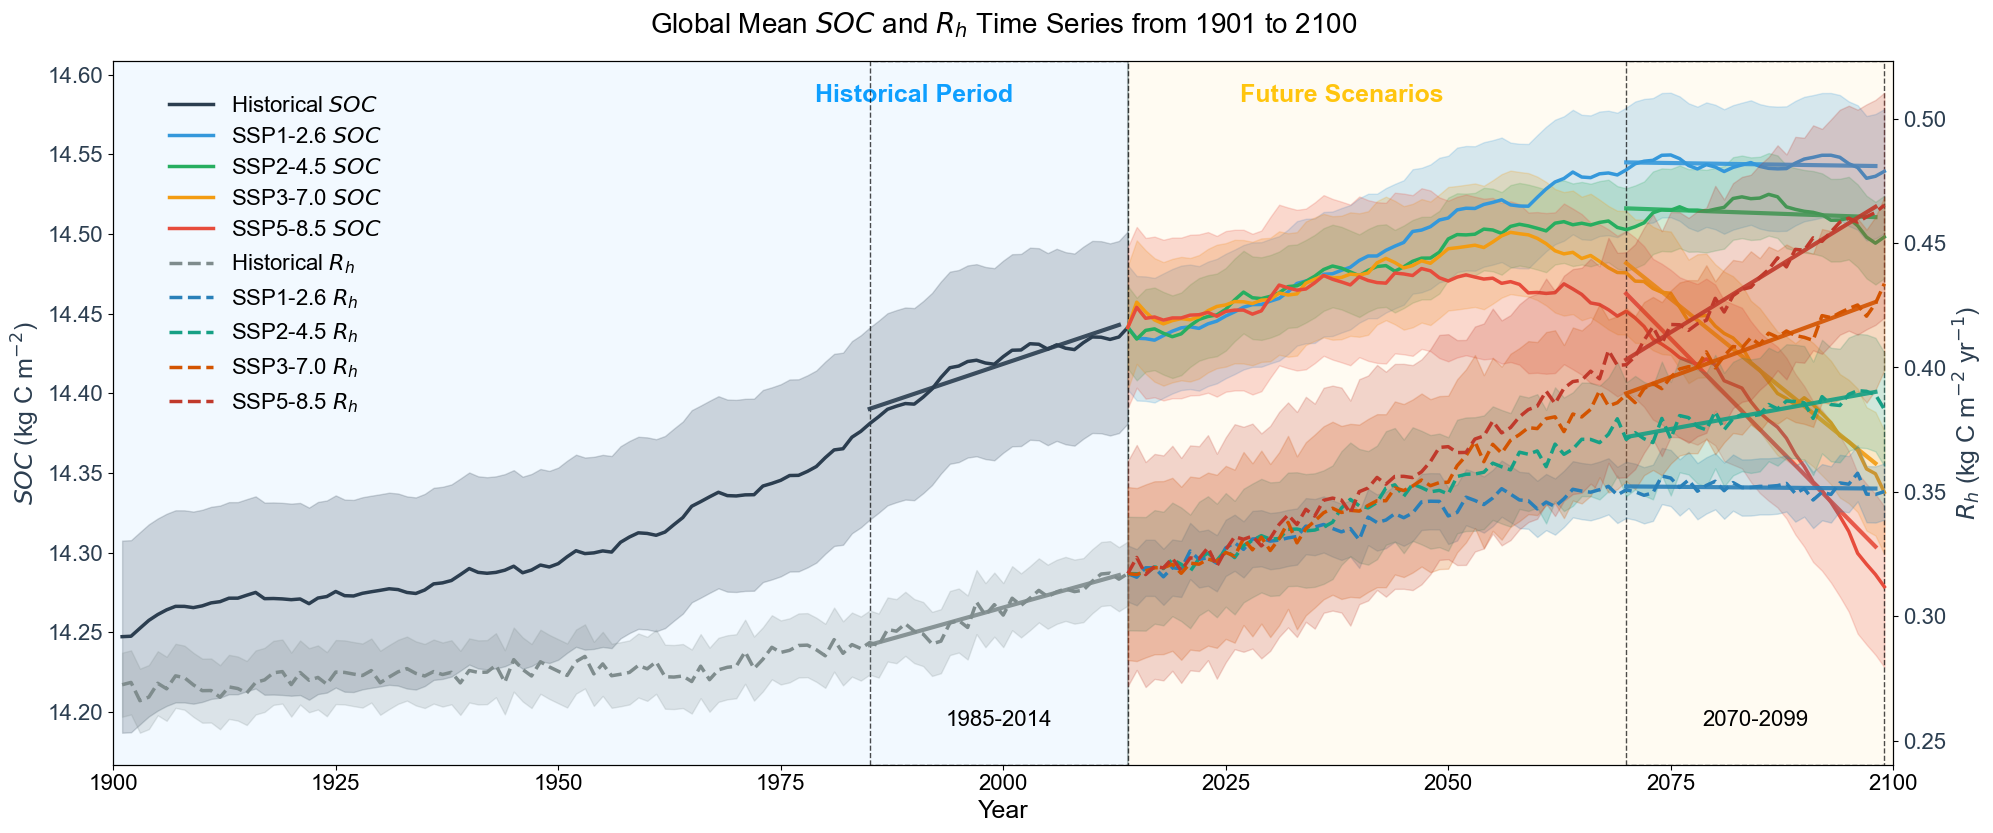

In [11]:
def create_supplementary_fig7():
    # 重置matplotlib默认样式，避免全局设置干扰
    plt.rcParams.update(plt.rcParamsDefault)
    # 明确设置子图背景色和边框默认值
    plt.rcParams['axes.facecolor'] = 'white'       # 子图背景白色
    plt.rcParams['axes.edgecolor'] = 'black'       # 边框默认黑色
    plt.rcParams.update({
        'font.family': 'serif',           # 主字体类型（serif衬线 / sans-serif无衬线）
        'font.serif': ['Arial'], # 衬线字体首选
        'font.sans-serif': ['Times New Roman'],      # 无衬线字体备选
    })

    # 创建图形和子图布局
    fig = plt.figure(figsize=(20, 8))

    # 创建2x1的子图布局（根据实际需求调整）
    gs = gridspec.GridSpec(1, 1, figure=fig, wspace=0.15, hspace=0.45, top=0.95, bottom=0.07, left=0.1, right=0.99)
    # 第一个子图（图1a）
    ax1 = fig.add_subplot(gs[0])
    mesh1 = plot_supplementary_fig8i(fig, ax1)

    plt.show()


if __name__ == '__main__':
    create_supplementary_fig7()

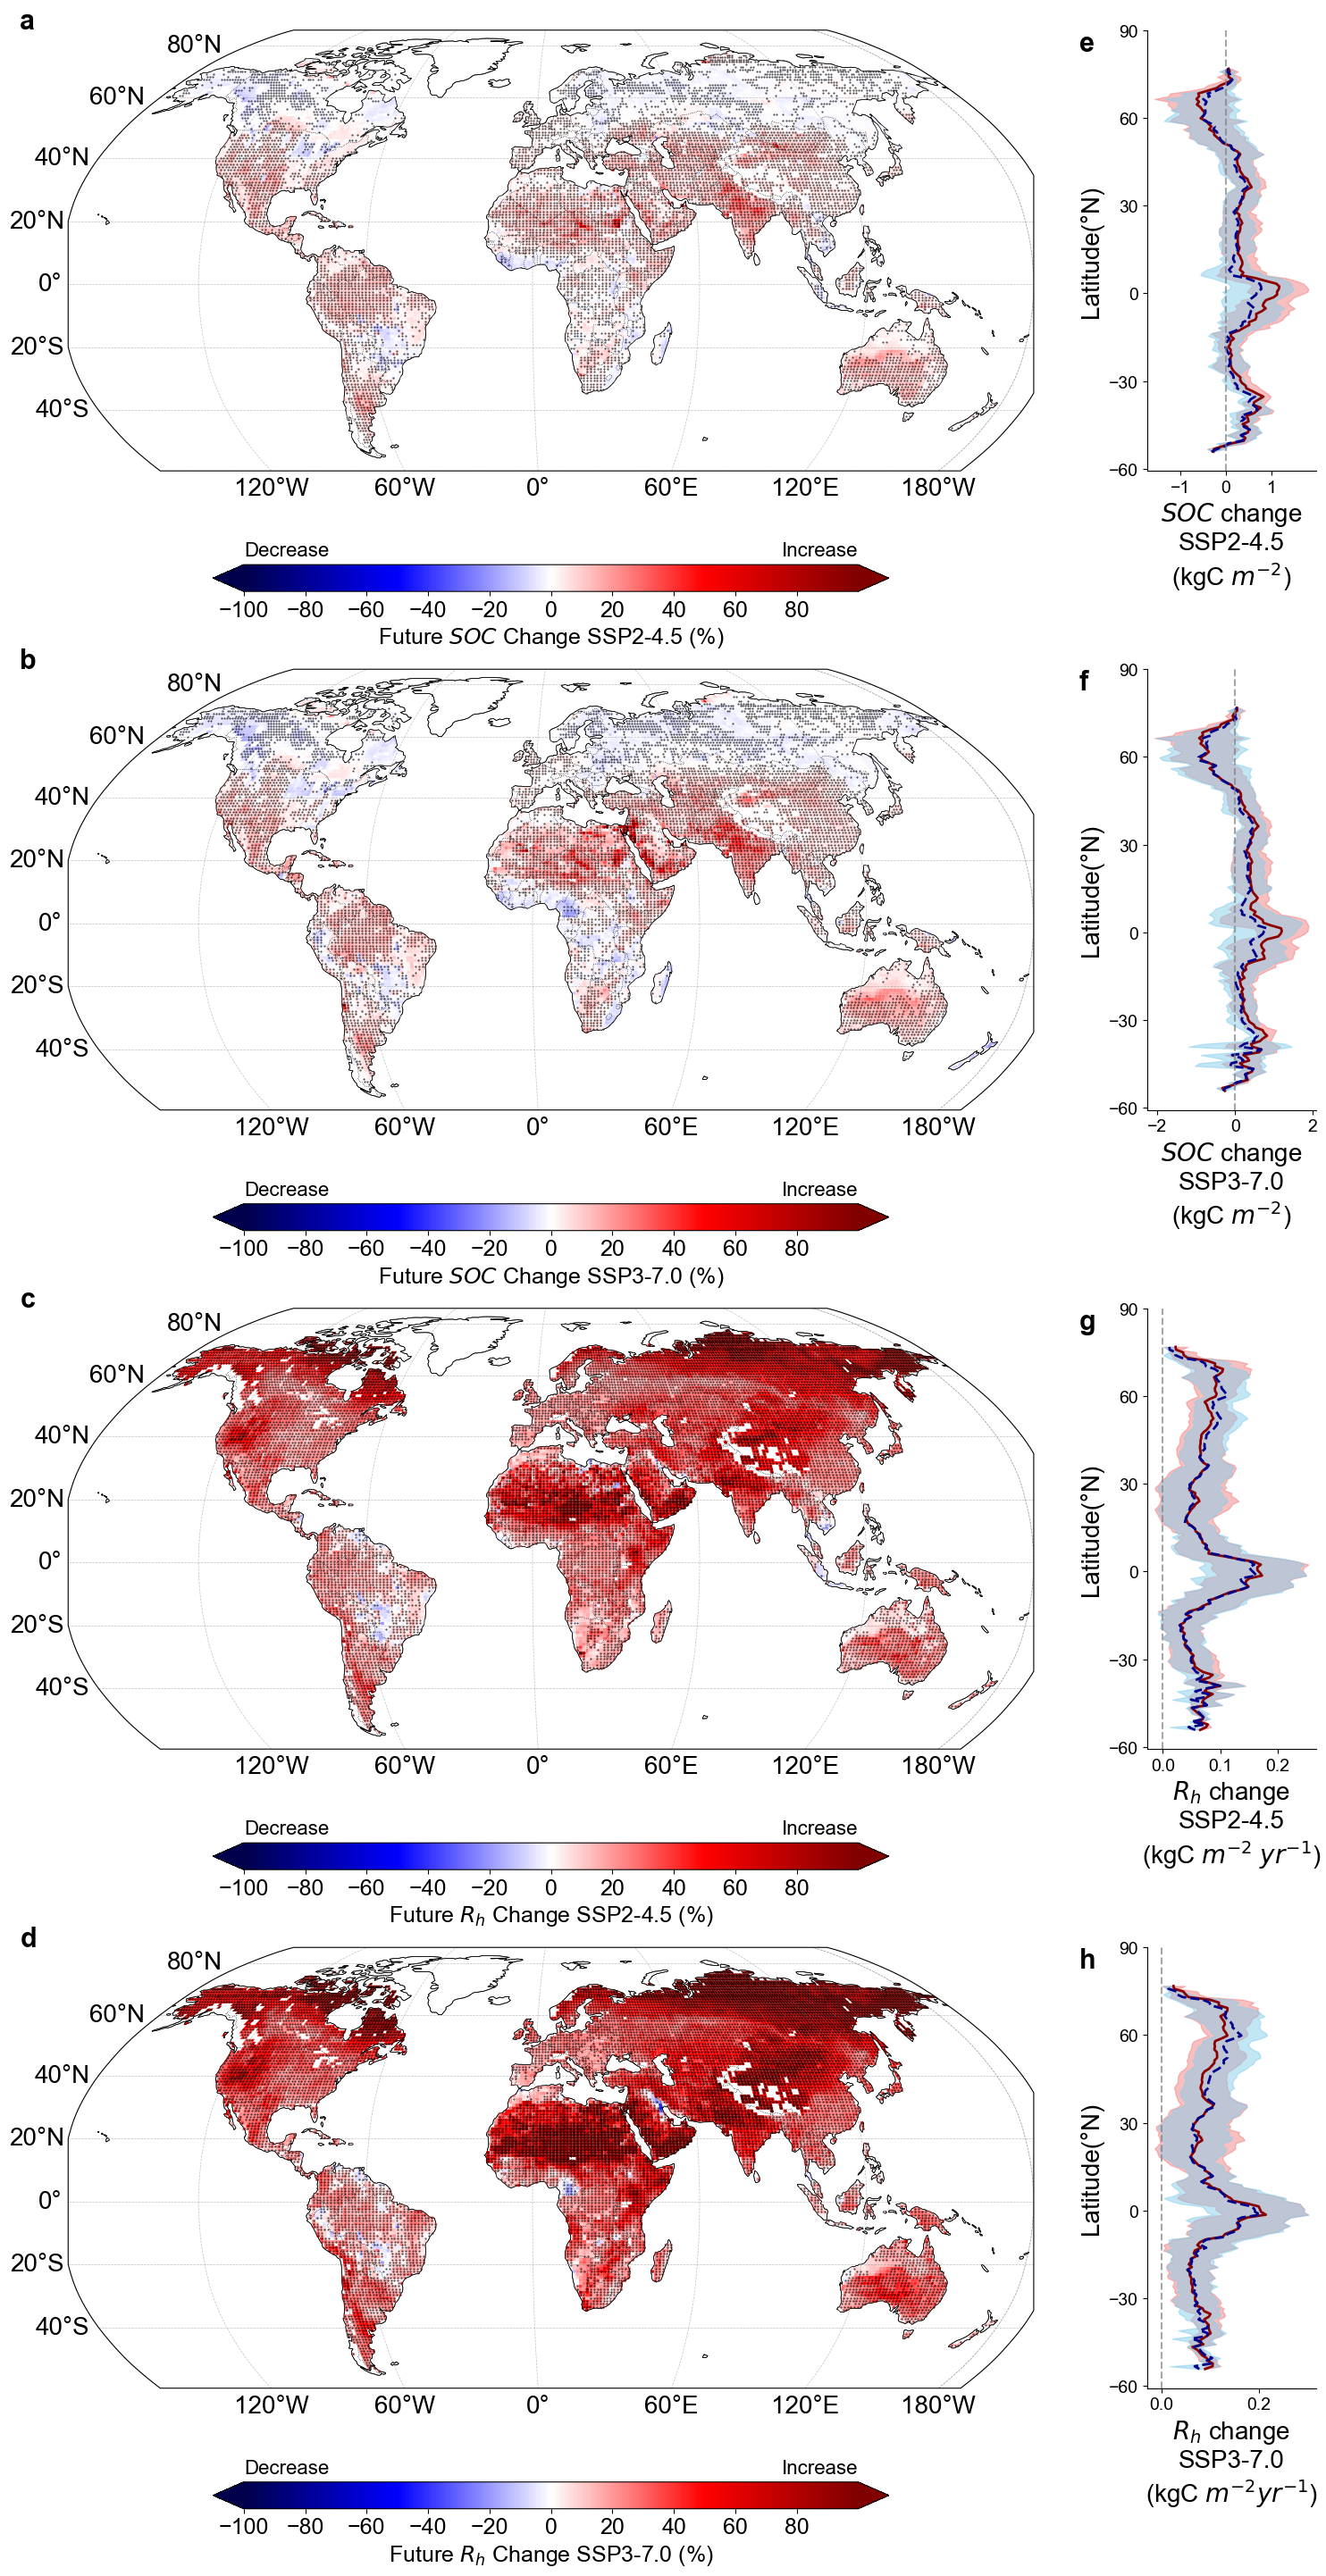

In [12]:
def create_supplementary_fig8():
    # 重置matplotlib默认样式，避免全局设置干扰
    plt.rcParams.update(plt.rcParamsDefault)
    # 明确设置子图背景色和边框默认值
    plt.rcParams['axes.facecolor'] = 'white'       # 子图背景白色
    plt.rcParams['axes.edgecolor'] = 'black'       # 边框默认黑色
    plt.rcParams.update({
        'font.family': 'serif',           # 主字体类型（serif衬线 / sans-serif无衬线）
        'font.serif': ['Arial'], # 衬线字体首选
        'font.sans-serif': ['Times New Roman'],      # 无衬线字体备选
    })

    # 创建图形和子图布局
    fig = plt.figure(figsize=(16, 30))

    # 创建2x1的子图布局（根据实际需求调整）
    gs = gridspec.GridSpec(4, 2, width_ratios=[6, 1], figure=fig, wspace=0.15, hspace=0.45, top=0.95, bottom=0.07, left=0.1, right=0.99)
    # 第一个子图（图1a）
    ax1 = fig.add_subplot(gs[0], projection=ccrs.Robinson(central_longitude=10))
    mesh1 = plot_supplementary_fig8a(fig, ax1)

    # 第二个子图（图1e）
    ax2 = fig.add_subplot(gs[1])
    mesh2 = plot_supplementary_fig8e(fig, ax2)

    # 第三个子图（图1b）
    ax3 = fig.add_subplot(gs[2], projection=ccrs.Robinson(central_longitude=10))
    mesh3 = plot_supplementary_fig8b(fig, ax3)

    # 第四个子图（图1f）
    ax4 = fig.add_subplot(gs[3])
    mesh4 = plot_supplementary_fig8f(fig, ax4)

    # 第五个子图（图1c）
    ax5 = fig.add_subplot(gs[4], projection=ccrs.Robinson(central_longitude=10))
    mesh5 = plot_supplementary_fig8c(fig, ax5)

    # 第六个子图（图1g）
    ax6 = fig.add_subplot(gs[5])
    mesh6 = plot_supplementary_fig8g(fig, ax6)

    # 第七个子图（图1d）
    ax7 = fig.add_subplot(gs[6], projection=ccrs.Robinson(central_longitude=10))
    mesh7 = plot_supplementary_fig8d(fig, ax7)

    # 第八个子图（图1h）
    ax8 = fig.add_subplot(gs[7])
    mesh8 = plot_supplementary_fig8h(fig, ax8)
    
    plt.show()
    

if __name__ == '__main__':
    create_supplementary_fig8()